# Mental Health Chatbot

## Introduction

## SDGs

# Initial Procedure

The following procedure to train a mental health chatbot is taken from https://github.com/pandeyanuradha/Chatbot-for-mental-health/blob/main/Models/Generative_based.ipynb.

In the second part of this document, techniques to improve the quality of the procedure are analysed.

## Loading data and preliminary analysis

This code snippet sets up the environment for the mental health chatbot by installing necessary libraries from a `requirements.txt` file using `pip`.

In [1]:
import os
os.chdir('./mental-health-chatbot')

In [4]:
# Install dependencies

%conda install --yes --file 'requirements.txt'

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.5.0
    latest version: 24.9.2

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import random
import numpy as np
import torch

seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

The following code snippet imports necessary libraries for building and visualizing the mental health chatbot. It imports `re` for regular expressions, `random` for generating random numbers, `pandas` for data manipulation, `numpy` for numerical operations, `plot_model` from `tensorflow.keras.utils` for visualizing the model structure, `load_model` from `keras.models` for loading pre-trained models, and `matplotlib.pyplot` for plotting graphs. Additionally, it sets a pandas option to suppress chained assignment warnings. These imports and configuration settings prepare the environment for subsequent steps in the chatbot development process.

In [6]:
import re
import pandas as pd
from keras.utils import plot_model
from keras.models import load_model
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)
path_to_csv = 'mentalhealth.csv'

2024-11-16 19:36:40.543601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 19:36:40.558683: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 19:36:40.563355: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 19:36:40.574678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Pandas is used to load the training data from the `mentalhealth.csv` file into a DataFrame. Only the first 20 rows are considered for now.

In [7]:
data = pd.read_csv(path_to_csv)

The first 5 rows of the DataFrame are examined.

In [8]:
data.head(5)

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,1619387,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


The DataFrame has three columns:

1.   `Question_ID`: the unique ID of the row
2.   `Questions`: mental health related questions
3.   `Answers`: mental health related answers

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Question_ID  97 non-null     int64 
 1   Questions    97 non-null     object
 2   Answers      97 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


There are 3 columns and 97 rows in the dataset.

In [10]:
data.shape

(97, 3)

`data.isna().sum()` helps identify the presence and count of missing values within the dataset, allowing to assess data quality and potentially handle missing values before proceeding with further analysis or model training. No values are missing in this dataset.

In [11]:
data.isna().sum()

Question_ID    0
Questions      0
Answers        0
dtype: int64

This code block focuses on cleaning and preparing the 'Answers' column of the dataset for further use. It iterates through each answer in the dataset and applies a series of regular expression substitutions to remove or replace specific characters and patterns. Special characters that interfere with model training are removed. They don't contribute to the meaning of text when processed by algorithms and can introduce errors or confusion. Therefore, it's necessary to remove them during text analysis.



In [12]:
# data preprocessing

for i in range(data.shape[0]):
  data.loc[i, 'Answers'] = re.sub(r'\n', ' ', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub('\(', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'\)', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r',', ' ', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'-', '', data.loc[i, 'Answers'])
  data.loc[i, 'Answers'] = re.sub(r'/', '', data.loc[i, 'Answers'])

In the following section a list of question and answer pairs is created. It is used in the following steps of the procedure.

In [13]:
pairs = []

for i in range(data.shape[0]):
  pairs.append(((data['Questions'][i]), data['Answers'][i]))

In [14]:
pairs[0]

('What does it mean to have a mental illness?',
 "Mental illnesses are health conditions that disrupt a person's thoughts  emotions  relationships  and daily functioning.")

## Data preprocessing

The following code snippet creates lists of questions, answers, question word counts and answer word counts. `<START>` and `<END>` tokens are added to the beginning and end of each answer to help the model understand the start and end of a response. All indivudial words in the questions and answers are added to vocabulary sets.

> Vocabulary in NLP refers to the set of unique words that the system knows from a corpus. It's crucial because it forms the basis of how machines interpret the texts. Each word in the vocabulary is indexed and often given a vector representation that captures its meaning and relation to other words.

-- A S M Morshedul Hoque

In [15]:
questions = []
answers = []
question_tokens = set()
answer_tokens = set()

for line in pairs:
  question, answer = line[0], line[1]

  questions.append(question)

  # Splitting words from punctuation
  answer = " ".join(re.findall(r"[\w']+|[^\s\w]", answer))

  # Redefine answer and append it to answers
  answer = '<START> ' + answer + ' <END>'

  answers.append(answer)

  for token in re.findall(r"[\w']+|[^\s\w]", question):
    if token not in question_tokens:
      question_tokens.add(token)

  for token in answer.split():
    if token not in answer_tokens:
      answer_tokens.add(token)

question_tokens = sorted(list(question_tokens))
answer_tokens = sorted(list(answer_tokens))
num_encoder_tokens = len(question_tokens)
num_decoder_tokens = len(answer_tokens)

In [16]:
questions

['What does it mean to have a mental illness?',
 'Who does mental illness affect?',
 'What are some of the warning signs of mental illness?',
 'Can people with mental illness recover?',
 'What should I do if I know someone who appears to have the symptoms of a mental disorder?',
 'How can I find a mental health professional for myself or my child?',
 'What treatment options are available?',
 'If I become involved in treatment, what do I need to know?',
 'What is the difference between mental health professionals?',
 'How can I find a mental health professional right for my child or myself?',
 'If I become involved in treatment what do I need to know?',
 'Where else can I get help?',
 'What should I know before starting a new medication?',
 'If I feel better after taking medication, does this mean I am "cured" and can stop taking it?',
 'How can I get help paying for my medication?',
 'Where can I go to find therapy',
 'Where can I learn about types of mental health treatment?',
 'What 

In [17]:
answers

["<START> Mental illnesses are health conditions that disrupt a person's thoughts emotions relationships and daily functioning . <END>",
 '<START> Mental illness does can affect anyone regardless of gender age income social status ethnicity religion sexual orientation or background . <END>',
 '<START> Symptoms of mental health disorders vary depending on the type and severity of the condition . <END>',
 '<START> When healing from mental illness early identification and treatment are of vital importance . <END>',
 '<START> We encourage those with symptoms to talk to their friends and family members and seek the counsel of a mental health professional . <END>',
 '<START> Feeling comfortable with the professional you or your child is working with is critical to the success of the treatment . <END>',
 '<START> Different treatment options are available for individuals with mental illness . <END>',
 '<START> It is important to be as involved and engaged in the treatment process as possible .

This code snippet is creating dictionaries to map words to numerical indices and vice versa for both the questions (input) and the answers (target). This is a common step in NLP because machine learning models work with numbers, not raw text.

In [18]:
input_features_dict = dict([(token, i) for i, token in enumerate(question_tokens)])
target_features_dict = dict([(token, i) for i, token in enumerate(answer_tokens)])

reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

In [19]:
print('There are {} tokens in the input (question) vocabulary'.format(len(input_features_dict)))
print('There are {} tokens in the target (answer) vocabulary'.format(len(target_features_dict)))

There are 282 tokens in the input (question) vocabulary
There are 3101 tokens in the target (answer) vocabulary


## Encoder - Decoder Model

In the following code section one-hot encoded input and target sequences are created for model training.

One-hot encoding is a method for converting each token into a binary vector. This allows machine learning models to work with categorial data.

Neural networks require inputs of consistent shapes. Therefore, the maximum sequence lengths set the dimensions for the longest possible sequence, ensuring each sequence fits within the tensor shape. This avoids dimension mismatches that would cause errors during model training.

Not all input or output sequences will be as long as the maximum sequence length. So, sequences that are shorter get "padded" with zeros up to the maximum length.

Each token in the sequences is represented as a vector. A vector has a length equal to the vocabulary size and a specific position corresponding to the token's index in the vocabulary is set to 1, while all other positions are 0.

`decoder_target_data` is offset by one timestep; this is used for teacher forcing during training, where the target output at time `t` depends on the decoder input at time` t-1`.




In [20]:
max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in questions])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in answers])

encoder_input_data = np.zeros(
    (len(questions), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(questions), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(answers), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(questions, answers)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        encoder_input_data[line, timestep, input_features_dict[token]] = 1

    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1

The shapes of the encoder and decoder arrays:

In [21]:
encoder_input_data.shape

(97, 53, 282)

In [22]:
decoder_target_data.shape

(97, 1642, 3101)

## Training

The following code snippet is essentially building the core of a chatbot using a specific type of neural network architecture called an encoder-decoder model with LSTM (Long Short-Term Memory) layers. LSTM is a type of recurrent neural network layer that's good at processing sequential data like text.

In [40]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model

# This determines the size of the internal representation of the data within
# the LSTM units. A higher dimensionality can capture more complex patterns
# but may increase computational cost.
dimensionality = 256

# Specifies the batch size for training. The batch size is the number of
# samples processed before the model's internal parameters are updated.
batch_size = 16

# Defines the number of training epochs. An epoch is one complete pass
# through the entire training dataset.
epochs = 100

# This code snippet defines the encoder part of a sequence-to-sequence model,
# where encoder_inputs is created as an input layer to receive variable-length
# sequences. An LSTM layer, encoder_lstm, processes this input to understand the
# sequence and produces encoder_outputs along with its internal states
# (state_hidden, state_cell), which are then stored as encoder_states to be
# passed to the decoder, effectively capturing the essence of the input sequence.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

# The decoder takes the encoded information from the encoder, processes it
# step-by-step using the LSTM, and uses the Dense output layer to predict the
# next word in the response, ultimately generating a complete response sequence.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# The `softmax` activation function converts the output of the Dense layer
# into probabilities. Each probability represents the likelihood of a particular
# token being the next word in the response.
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

The following line creates the final training model by combining the encoder and decoder components.

In [41]:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

The flow of the model:

1. The encoder LSTM (`lstm_2`) processes the `input_layer_8`
sequence (with 86 features per timestep).
3. The decoder LSTM (`lstm_3`) processes `input_layer_9` (decoder input with 172 features) and uses `lstm_2`'s output to generate an output sequence.
4. The dense layer (`dense_1`) converts the output of `lstm_3` into a vector of size 172, matching the target vocabulary for predictions.

In summary, this model is structured for generating sequences, where an input sequence is encoded and then decoded to produce an output sequence.

In [42]:
training_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None, 282) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ 3101)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ [(None, 256),     │    551,936 │ input_layer_10[0… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ [(None, None,     │  3,438,592 │ input_layer_11[0… │
│                     │ 256), (None,      │            │ lstm_6[0][1],     │
│                     │ 256), (None,      │            │ lstm_6[0][2]      │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, None,      │    796,957 │ lstm_7[0][0]      │
│                     │ 3101)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,787,485 (18.26 MB)

 Trainable params: 4,787,485 (18.26 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
%pip install pydot

Note: you may need to restart the kernel to use updated packages.


In [31]:
plot_model(training_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


The following code compiles the model using the `rmsprop` optimizer, `categorical_crossentropy` loss function (suitable for one-hot encoded targets), and accuracy as a performance metric. It then trains `training_model` on `encoder_input_data` and `decoder_input_data` (the input sequences for the encoder and decoder) to predict `decoder_target_data`, with training running for the specified number of epochs and batch size, and using 20% of the data for validation. Finally, the trained model is saved to a file named `training_model.keras` for future use.

In [43]:
training_model.compile(optimizer='adam', loss='categorical_crossentropy')
history1=training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.1)
training_model.save('training_model.keras')

2024-11-16 19:59:44.219766: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1771961016 exceeds 10% of free system memory.


Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_63', 'keras_tensor_67']. Received: the structure of inputs=('*', '*')
  warnings.warn(


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 475ms/step - loss: 1.4357 - val_loss: 1.7832
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - loss: 1.2227 - val_loss: 1.6094
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - loss: 1.2313 - val_loss: 1.5132
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 356ms/step - loss: 0.9943 - val_loss: 1.5075
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - loss: 1.1040 - val_loss: 1.5025
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 357ms/step - loss: 1.1347 - val_loss: 1.5029
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - loss: 0.9565 - val_loss: 1.5050
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - loss: 1.1943 - val_loss: 1.5053
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 348ms/step - loss: 1.0948 - val_loss: 1.5048
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - loss: 1.0421 - val_loss: 1.5037
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - loss: 1.0247 - val_loss: 1.5030
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - loss: 0.9502 - val_lo

KeyboardInterrupt: 

Training and validation accuracy and loss are visualized in the following graphs. We can see that:
* Training Accuracy (blue line) increases steadily, indicating that the model is learning and fitting the training data better as epochs progress.
* Validation Accuracy (orange line) improves initially but plateaus and fluctuates after a certain point. This suggests that, while the model is improving on the training data, its generalization to unseen (validation) data does not improve beyond a certain accuracy level, likely due to overfitting.
* Training Loss (blue line) decreases continuously, showing that the model is reducing its error on the training data, which is expected as the model fits the training data better with more epochs.
* Validation Loss (orange line) initially decreases but starts to increase and fluctuate after a certain point, indicating that the model is starting to overfit. This means it is learning the training data too well but fails to generalize to new data, resulting in higher error on the validation set.

In summary, the model shows signs of **overfitting**: while the training accuracy and loss continue to improve, the validation accuracy plateaus, and the validation loss increases. This suggests that the model is fitting the training data too closely, and its performance on unseen data could be improved by using techniques like early stopping, regularization, or reducing the model complexity.

The following chapters focus on improving the accuracy and quality of the model.

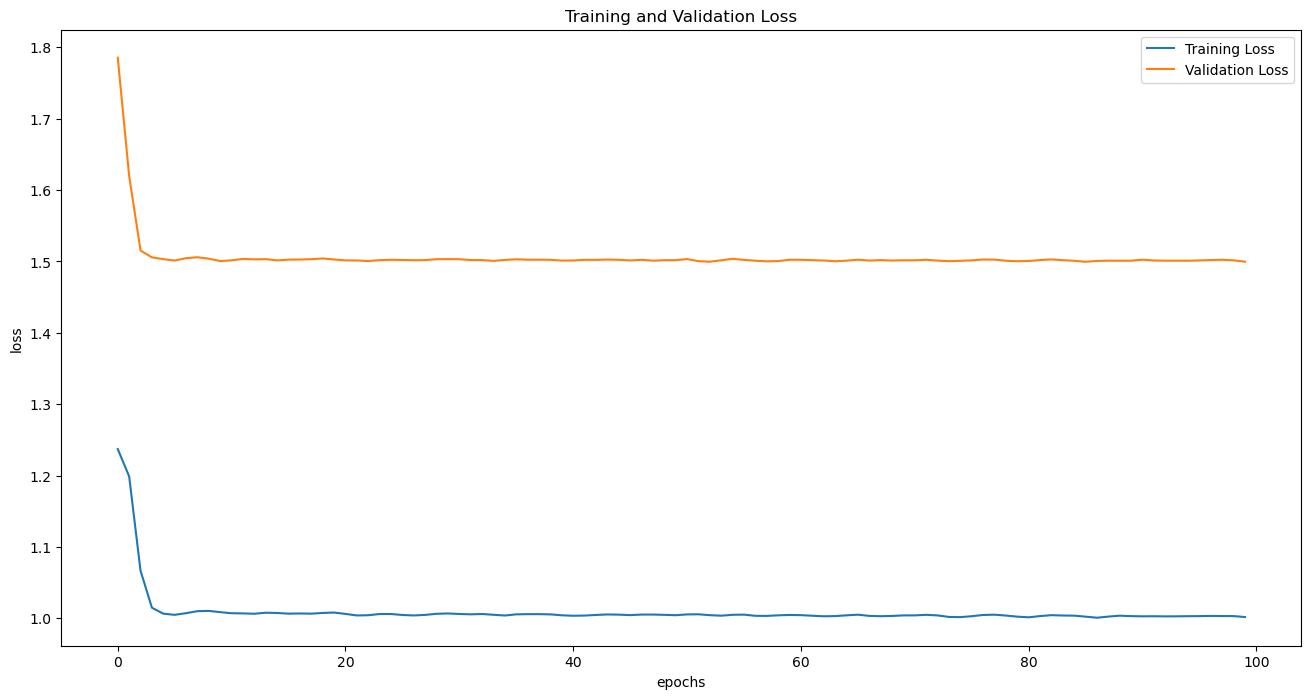

In [46]:
loss=history1.history['loss']
val_loss=history1.history['val_loss']

plt.figure(figsize=(16,8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
from keras.models import load_model

training_model = load_model('training_model.keras')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
training_model = load_model('training_model.keras')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
          
          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token
          
          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True
          
          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
          
          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. AMA!\n")
    
    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)
  
  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
    
  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
chatbot = ChatBot()


In [45]:
chatbot.start_chat()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/opt/conda/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_67', 'keras_tensor_102', 'keras_tensor_103']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

# Model Improvements

The initial procedure is largely taken from this source: https://github.com/pandeyanuradha/Chatbot-for-mental-health/blob/main/Models/Generative_based.ipynb.

As previously shown, the current model tends to overfit.

In the following sections, different techniques are applied to improve the quality and accuracy of the model.

## Data preprocessing

The newest version of `torchtext` is not compatible with the installed `torch` version. Therefore, the following index URL is specified to gather compatible packages.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import torchtext
import tqdm


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/conda/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.11/site-packages/tornado

In [3]:
import pandas as pd

In [4]:
dataset = pd.read_csv('mentalhealth.csv')

In [5]:
dataset.head()

,Question_ID,Questions,Answers
0,1590140,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,2110618,Who does mental illness affect?,"Mental illness does can affect anyone, regardl..."
2,9434130,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
3,7657263,Can people with mental illness recover?,"When healing from mental illness, early identi..."
4,1619387,What should I do if I know someone who appears...,We encourage those with symptoms to talk to th...


In [6]:
from sklearn.model_selection import train_test_split

In [ ]:
# split again into test and validation
train_data, test_data = train_test_split(dataset, test_size=0.2)

In [8]:
train_data.head()

,Question_ID,Questions,Answers
90,4824231,What’s the difference between substance use an...,People tend to use the word “addiction” to mea...
51,6167248,When is substance use a problem? Where can I g...,Each person has a different relationship with ...
32,7069853,Why do I need to keep informed?,It may be tempting to try to block out the wor...
55,3284724,How do I apply for income assistance?,Provincial income assistance has three income ...
16,3268009,Where can I learn about types of mental health...,Mental health conditions are often treated wit...


In [9]:
!python -m spacy download en_core_web_sm
en_nlp = spacy.load("en_core_web_sm")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 189, in _run_module_as_main
  File "<frozen runpy>", line 148, in _get_module_details
  File "<frozen runpy>", line 112, in _get_module_details
  File "/opt/conda/lib/python3.11/site-packages/spacy/__init__.py", line 6, in <module>
    from .errors import setup_default_warnings
  File "/opt/conda/lib/python3.11/site-packages/spacy/errors.py", line 3, in <module>
    from .compat import Literal
  File "/opt/conda/lib/python3.11/site-packages/spacy/compat.py", line 4, in <module>
    from thinc.

In [10]:
string = "What a lovely day it is today!"

[token.text for token in en_nlp.tokenizer(string)]

['What', 'a', 'lovely', 'day', 'it', 'is', 'today', '!']

In [11]:
sos_token = "<sos>"
eos_token = "<eos>"

def tokenize(input):
  max_length = 1_000
  lower = True

  token_list = []
  for value in input:
    tokens = [token.text for token in en_nlp.tokenizer(value)[:max_length]]
    tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    token_list.append(tokens)
  return token_list

In [12]:
t_questions = tokenize(train_data['Questions'])
t_answers = tokenize(train_data['Answers'])

train_data['t_Questions'] = t_questions
train_data['t_Answers'] = t_answers

In [13]:
t_questions = tokenize(test_data['Questions'])
t_answers = tokenize(test_data['Answers'])

test_data['t_Questions'] = t_questions
test_data['t_Answers'] = t_answers

In [14]:
train_data.head(5)

,Question_ID,Questions,Answers,t_Questions,t_Answers
90,4824231,What’s the difference between substance use an...,People tend to use the word “addiction” to mea...,"[<sos>, what, ’s, the, difference, between, su...","[<sos>, people, tend, to, use, the, word, “, a..."
51,6167248,When is substance use a problem? Where can I g...,Each person has a different relationship with ...,"[<sos>, when, is, substance, use, a, problem, ...","[<sos>, each, person, has, a, different, relat..."
32,7069853,Why do I need to keep informed?,It may be tempting to try to block out the wor...,"[<sos>, why, do, i, need, to, keep, informed, ...","[<sos>, it, may, be, tempting, to, try, to, bl..."
55,3284724,How do I apply for income assistance?,Provincial income assistance has three income ...,"[<sos>, how, do, i, apply, for, income, assist...","[<sos>, provincial, income, assistance, has, t..."
16,3268009,Where can I learn about types of mental health...,Mental health conditions are often treated wit...,"[<sos>, where, can, i, learn, about, types, of...","[<sos>, mental, health, conditions, are, often..."


In [15]:
test_data.head(5)

,Question_ID,Questions,Answers,t_Questions,t_Answers
54,2176317,How can I pay for mental health care?,Mental health services provided through the go...,"[<sos>, how, can, i, pay, for, mental, health,...","[<sos>, mental, health, services, provided, th..."
91,4294616,How can I find help for an alcohol or drug use...,Seeking to make changes in the way you use sub...,"[<sos>, how, can, i, find, help, for, an, alco...","[<sos>, seeking, to, make, changes, in, the, w..."
37,9250044,How can I use distraction to manage difficult ...,Distraction is a very valid tool to help you c...,"[<sos>, how, can, i, use, distraction, to, man...","[<sos>, distraction, is, a, very, valid, tool,..."
89,6869967,I’m an adult and I think I might have ADHD. Wh...,While we think of attention-deficit/hyperactiv...,"[<sos>, i, ’m, an, adult, and, i, think, i, mi...","[<sos>, while, we, think, of, attention, -, de..."
75,8612349,What's the difference between anxiety and stress?,Stress and anxiety are often used interchangea...,"[<sos>, what, 's, the, difference, between, an...","[<sos>, stress, and, anxiety, are, often, used..."


In [16]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

question_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["t_Questions"],
    min_freq=min_freq,
    specials=special_tokens,
)

answer_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["t_Answers"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [17]:
question_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', '?', 'i', 'what', 'can', 'a', 'mental']

In [18]:
answer_vocab.get_itos()[:10]

['<unk>', '<pad>', '<sos>', '<eos>', ',', '.', 'to', 'and', 'a', 'the']

In [19]:
answer_vocab.get_stoi()['to']

6

In [20]:
len(question_vocab), len(answer_vocab)

(96, 1326)

In [21]:
assert question_vocab[unk_token] == answer_vocab[unk_token]
assert question_vocab[pad_token] == answer_vocab[pad_token]

unk_index = question_vocab[unk_token]
pad_index = question_vocab[pad_token]

In [22]:
question_vocab.set_default_index(unk_index)
answer_vocab.set_default_index(unk_index)

In [23]:
question_vocab['The']

0

In [24]:
question_vocab.get_itos()[0]

'<unk>'

In [25]:
tokens = ["i", "love", "watching", "crime", "shows"]

question_vocab.lookup_tokens(question_vocab.lookup_indices(tokens))

['i', 'love', '<unk>', '<unk>', '<unk>']

In [26]:
for value in train_data['t_Questions']:
  print(question_vocab.lookup_indices(value))

[2, 6, 35, 11, 19, 18, 86, 48, 12, 0, 4, 3]
[2, 0, 14, 86, 48, 8, 0, 4, 16, 7, 5, 44, 20, 21, 4, 3]
[2, 62, 15, 5, 57, 24, 0, 0, 4, 3]
[2, 10, 15, 5, 0, 20, 0, 0, 4, 3]
[2, 16, 7, 5, 54, 27, 93, 25, 9, 17, 92, 4, 3]
[2, 7, 0, 49, 9, 32, 0, 4, 3]
[2, 16, 7, 5, 44, 24, 13, 8, 88, 0, 4, 3]
[2, 5, 53, 0, 25, 87, 29, 26, 34, 5, 42, 27, 14, 0, 27, 87, 30, 6, 41, 5, 15, 4, 3]
[2, 34, 5, 77, 45, 68, 71, 49, 61, 30, 10, 7, 5, 21, 4, 3]
[2, 22, 5, 74, 0, 0, 89, 56, 29, 38, 0, 55, 5, 0, 63, 0, 63, 12, 7, 0, 89, 46, 4, 3]
[2, 16, 7, 5, 13, 0, 26, 0, 36, 0, 70, 4, 3]
[2, 62, 15, 5, 57, 8, 0, 4, 3]
[2, 6, 28, 11, 19, 18, 0, 12, 43, 4, 3]
[2, 16, 7, 5, 13, 85, 36, 21, 78, 20, 51, 4, 3]
[2, 10, 7, 5, 84, 8, 60, 4, 3]
[2, 6, 38, 46, 55, 24, 53, 8, 9, 32, 4, 3]
[2, 6, 41, 5, 39, 0, 0, 8, 0, 56, 4, 3]
[2, 6, 14, 0, 47, 23, 4, 3]
[2, 94, 38, 9, 32, 0, 4, 3]
[2, 10, 7, 5, 75, 21, 81, 20, 31, 56, 4, 3]
[2, 6, 41, 5, 15, 22, 5, 50, 0, 27, 8, 0, 26, 0, 4, 3]
[2, 10, 7, 5, 13, 8, 9, 17, 82, 0, 20, 31, 52, 26, 

In [27]:
def numericalize(input, vocab):
    values = []
    for value in input:
        values.append(vocab.lookup_indices(value))
    return values

In [28]:
n_questions = numericalize(train_data['t_Questions'], question_vocab)
n_answers = numericalize(train_data['t_Answers'], answer_vocab)

train_data['n_Questions'] = n_questions
train_data['n_Answers'] = n_answers

In [29]:
train_data.head()

,Question_ID,Questions,Answers,t_Questions,t_Answers,n_Questions,n_Answers
90,4824231,What’s the difference between substance use an...,People tend to use the word “addiction” to mea...,"[<sos>, what, ’s, the, difference, between, su...","[<sos>, people, tend, to, use, the, word, “, a...","[2, 6, 35, 11, 19, 18, 86, 48, 12, 0, 4, 3]","[2, 24, 931, 6, 45, 9, 1316, 209, 979, 210, 6,..."
51,6167248,When is substance use a problem? Where can I g...,Each person has a different relationship with ...,"[<sos>, when, is, substance, use, a, problem, ...","[<sos>, each, person, has, a, different, relat...","[2, 0, 14, 86, 48, 8, 0, 4, 16, 7, 5, 44, 20, ...","[2, 262, 113, 89, 8, 59, 358, 21, 233, 38, 159..."
32,7069853,Why do I need to keep informed?,It may be tempting to try to block out the wor...,"[<sos>, why, do, i, need, to, keep, informed, ...","[<sos>, it, may, be, tempting, to, try, to, bl...","[2, 62, 15, 5, 57, 24, 0, 0, 4, 3]","[2, 27, 25, 30, 0, 6, 207, 6, 0, 93, 9, 413, 0..."
55,3284724,How do I apply for income assistance?,Provincial income assistance has three income ...,"[<sos>, how, do, i, apply, for, income, assist...","[<sos>, provincial, income, assistance, has, t...","[2, 10, 15, 5, 0, 20, 0, 0, 4, 3]","[2, 897, 432, 478, 89, 534, 432, 859, 44, 0, 4..."
16,3268009,Where can I learn about types of mental health...,Mental health conditions are often treated wit...,"[<sos>, where, can, i, learn, about, types, of...","[<sos>, mental, health, conditions, are, often...","[2, 16, 7, 5, 54, 27, 93, 25, 9, 17, 92, 4, 3]","[2, 26, 23, 568, 22, 145, 758, 21, 321, 4, 150..."


In [30]:
n_questions = numericalize(test_data['t_Questions'], question_vocab)
n_answers = numericalize(test_data['t_Answers'], answer_vocab)

test_data['n_Questions'] = n_questions
test_data['n_Answers'] = n_answers

In [31]:
test_data.head()

,Question_ID,Questions,Answers,t_Questions,t_Answers,n_Questions,n_Answers
54,2176317,How can I pay for mental health care?,Mental health services provided through the go...,"[<sos>, how, can, i, pay, for, mental, health,...","[<sos>, mental, health, services, provided, th...","[2, 10, 7, 5, 0, 20, 9, 17, 42, 4, 3]","[2, 26, 23, 110, 0, 125, 9, 500, 19, 0, 39, 20..."
91,4294616,How can I find help for an alcohol or drug use...,Seeking to make changes in the way you use sub...,"[<sos>, how, can, i, find, help, for, an, alco...","[<sos>, seeking, to, make, changes, in, the, w...","[2, 10, 7, 5, 13, 21, 20, 67, 0, 26, 0, 48, 0,...","[2, 1245, 6, 109, 335, 15, 9, 98, 10, 45, 233,..."
37,9250044,How can I use distraction to manage difficult ...,Distraction is a very valid tool to help you c...,"[<sos>, how, can, i, use, distraction, to, man...","[<sos>, distraction, is, a, very, valid, tool,...","[2, 10, 7, 5, 48, 0, 24, 0, 0, 0, 26, 0, 4, 3]","[2, 0, 17, 8, 134, 0, 409, 6, 29, 10, 311, 54,..."
89,6869967,I’m an adult and I think I might have ADHD. Wh...,While we think of attention-deficit/hyperactiv...,"[<sos>, i, ’m, an, adult, and, i, think, i, mi...","[<sos>, while, we, think, of, attention, -, de...","[2, 5, 50, 67, 66, 12, 5, 0, 5, 0, 53, 0, 30, ...","[2, 173, 79, 139, 11, 994, 19, 0, 467, 0, 63, ..."
75,8612349,What's the difference between anxiety and stress?,Stress and anxiety are often used interchangea...,"[<sos>, what, 's, the, difference, between, an...","[<sos>, stress, and, anxiety, are, often, used...","[2, 6, 28, 11, 19, 18, 51, 12, 0, 4, 3]","[2, 530, 7, 73, 22, 145, 365, 0, 4, 7, 94, 17,..."


In [32]:
import datasets

train_data = datasets.Dataset.from_dict(train_data)
test_data = datasets.Dataset.from_dict(test_data)

In [33]:
data_type = "torch"
format_columns = ["n_Questions", "n_Answers"]

train_data = train_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

In [34]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_questions = [example["n_Questions"] for example in batch]
        batch_answers = [example["n_Answers"] for example in batch]
        batch_questions = nn.utils.rnn.pad_sequence(batch_questions, padding_value=pad_index)
        batch_answers = nn.utils.rnn.pad_sequence(batch_answers, padding_value=pad_index)
        batch = {
            "n_Questions": batch_questions,
            "n_Answers": batch_answers,
        }
        return batch

    return collate_fn

In [35]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [36]:
batch_size = 16

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## Encoder - Decoder Model

In [37]:
class Encoder(nn.Module):
    def __init__(
        self, input_dim, embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout
    ):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.GRU(embedding_dim, encoder_hidden_dim, bidirectional=True)
        self.fc = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))
        # embedded = [src length, batch size, embedding dim]
        outputs, hidden = self.rnn(embedded)
        # outputs = [src length, batch size, hidden dim * n directions]
        # hidden = [n layers * n directions, batch size, hidden dim]
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        # hidden [-2, :, : ] is the last of the forwards RNN
        # hidden [-1, :, : ] is the last of the backwards RNN
        # initial decoder hidden is final hidden state of the forwards and backwards
        # encoder RNNs fed through a linear layer
        hidden = torch.tanh(
            self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        )
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        return outputs, hidden

In [38]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super().__init__()
        self.attn_fc = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim, decoder_hidden_dim
        )
        self.v_fc = nn.Linear(decoder_hidden_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        batch_size = encoder_outputs.shape[1]
        src_length = encoder_outputs.shape[0]
        # repeat decoder hidden state src_length times
        hidden = hidden.unsqueeze(1).repeat(1, src_length, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # hidden = [batch size, src length, decoder hidden dim]
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        energy = torch.tanh(self.attn_fc(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch size, src length, decoder hidden dim]
        attention = self.v_fc(energy).squeeze(2)
        # attention = [batch size, src length]
        return torch.softmax(attention, dim=1)

In [39]:
class Decoder(nn.Module):
    def __init__(
        self,
        output_dim,
        embedding_dim,
        encoder_hidden_dim,
        decoder_hidden_dim,
        dropout,
        attention,
    ):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, embedding_dim)
        self.rnn = nn.GRU((encoder_hidden_dim * 2) + embedding_dim, decoder_hidden_dim)
        self.fc_out = nn.Linear(
            (encoder_hidden_dim * 2) + decoder_hidden_dim + embedding_dim, output_dim
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input = [batch size]
        # hidden = [batch size, decoder hidden dim]
        # encoder_outputs = [src length, batch size, encoder hidden dim * 2]
        input = input.unsqueeze(0)
        # input = [1, batch size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, embedding dim]
        a = self.attention(hidden, encoder_outputs)
        # a = [batch size, src length]
        a = a.unsqueeze(1)
        # a = [batch size, 1, src length]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch size, src length, encoder hidden dim * 2]
        weighted = torch.bmm(a, encoder_outputs)
        # weighted = [batch size, 1, encoder hidden dim * 2]
        weighted = weighted.permute(1, 0, 2)
        # weighted = [1, batch size, encoder hidden dim * 2]
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input = [1, batch size, (encoder hidden dim * 2) + embedding dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        # output = [seq length, batch size, decoder hid dim * n directions]
        # hidden = [n layers * n directions, batch size, decoder hid dim]
        # seq len, n layers and n directions will always be 1 in this decoder, therefore:
        # output = [1, batch size, decoder hidden dim]
        # hidden = [1, batch size, decoder hidden dim]
        # this also means that output == hidden
        assert (output == hidden).all()
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))
        # prediction = [batch size, output dim]
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [40]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio):
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        batch_size = src.shape[1]
        trg_length = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        # tensor to store decoder outputs
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)
        # encoder_outputs is all hidden states of the input sequence, back and forwards
        # hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        # outputs = [src length, batch size, encoder hidden dim * 2]
        # hidden = [batch size, decoder hidden dim]
        # first input to the decoder is the <sos> tokens
        input = trg[0, :]
        for t in range(1, trg_length):
            # insert input token embedding, previous hidden state and all encoder hidden states
            # receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            # output = [batch size, output dim]
            # hidden = [n layers, batch size, decoder hidden dim]
            # place predictions in a tensor holding predictions for each token
            outputs[t] = output
            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            # get the highest predicted token from our predictions
            top1 = output.argmax(1)
            # if teacher forcing, use actual next token as next input
            # if not, use predicted token
            input = trg[t] if teacher_force else top1
            # input = [batch size]
        return outputs

In [41]:
input_dim = len(question_vocab)
output_dim = len(answer_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention
)

model = Seq2Seq(encoder, decoder, device).to(device)

In [42]:
def init_weights(m):
    for name, param in m.named_parameters():
        if "weight" in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(96, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn_fc): Linear(in_features=1536, out_features=512, bias=True)
      (v_fc): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(1326, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=1326, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 9,174,830 trainable parameters


In [44]:
optimizer = optim.Adam(model.parameters())

In [45]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

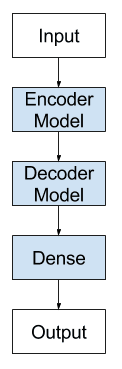

In [46]:
def train_fn(
    model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device
):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(data_loader):
        src = batch["n_Questions"].to(device)
        trg = batch["n_Answers"].to(device)
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio)
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [47]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["n_Questions"].to(device)
            trg = batch["n_Answers"].to(device)
            # src = [src length, batch size]
            # trg = [trg length, batch size]
            output = model(src, trg, 0)  # turn off teacher forcing
            # output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            # output = [(trg length - 1) * batch size, trg vocab size]
            trg = trg[1:].view(-1)
            # trg = [(trg length - 1) * batch size]
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

In [50]:
n_epochs = 100
clip = 1.0
teacher_forcing_ratio = 0.5

training_losses = []
validation_losses = []

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        test_data_loader,
        criterion,
        device,
    )

    training_losses.append(train_loss)
    validation_losses.append(valid_loss)
    
    if (epoch % 10 == 0):
        torch.save(model, "tut2-model.pth")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  1%|          | 1/100 [00:18<31:12, 18.92s/it]

	Train Loss:   6.528 | Train PPL: 683.782
	Valid Loss:   5.613 | Valid PPL: 273.899


  2%|▏         | 2/100 [00:37<30:09, 18.47s/it]

	Train Loss:   5.907 | Train PPL: 367.554
	Valid Loss:   5.493 | Valid PPL: 243.070


  3%|▎         | 3/100 [00:54<29:12, 18.06s/it]

	Train Loss:   5.729 | Train PPL: 307.621
	Valid Loss:   5.515 | Valid PPL: 248.299


  4%|▍         | 4/100 [01:10<27:25, 17.14s/it]

	Train Loss:   5.697 | Train PPL: 297.994
	Valid Loss:   5.507 | Valid PPL: 246.380


  5%|▌         | 5/100 [01:29<28:15, 17.84s/it]

	Train Loss:   5.690 | Train PPL: 295.928
	Valid Loss:   5.482 | Valid PPL: 240.405


  6%|▌         | 6/100 [01:46<27:30, 17.56s/it]

	Train Loss:   5.680 | Train PPL: 293.067
	Valid Loss:   5.482 | Valid PPL: 240.407


  7%|▋         | 7/100 [02:04<27:23, 17.67s/it]

	Train Loss:   5.667 | Train PPL: 289.255
	Valid Loss:   5.484 | Valid PPL: 240.883


  8%|▊         | 8/100 [02:22<27:21, 17.84s/it]

	Train Loss:   5.655 | Train PPL: 285.676
	Valid Loss:   5.488 | Valid PPL: 241.689


  9%|▉         | 9/100 [02:39<26:50, 17.70s/it]

	Train Loss:   5.643 | Train PPL: 282.315
	Valid Loss:   5.490 | Valid PPL: 242.273


 10%|█         | 10/100 [02:57<26:19, 17.55s/it]

	Train Loss:   5.617 | Train PPL: 275.197
	Valid Loss:   5.488 | Valid PPL: 241.879


 11%|█         | 11/100 [03:14<26:07, 17.61s/it]

	Train Loss:   5.590 | Train PPL: 267.718
	Valid Loss:   5.487 | Valid PPL: 241.453


 12%|█▏        | 12/100 [03:31<25:13, 17.20s/it]

	Train Loss:   5.562 | Train PPL: 260.297
	Valid Loss:   5.492 | Valid PPL: 242.706


 13%|█▎        | 13/100 [03:48<25:03, 17.29s/it]

	Train Loss:   5.533 | Train PPL: 252.885
	Valid Loss:   5.528 | Valid PPL: 251.587


 14%|█▍        | 14/100 [04:05<24:39, 17.20s/it]

	Train Loss:   5.475 | Train PPL: 238.686
	Valid Loss:   5.536 | Valid PPL: 253.596


 15%|█▌        | 15/100 [04:21<23:56, 16.90s/it]

	Train Loss:   5.451 | Train PPL: 233.046
	Valid Loss:   5.506 | Valid PPL: 246.277


 16%|█▌        | 16/100 [04:38<23:34, 16.84s/it]

	Train Loss:   5.391 | Train PPL: 219.346
	Valid Loss:   5.524 | Valid PPL: 250.732


 17%|█▋        | 17/100 [04:56<23:53, 17.28s/it]

	Train Loss:   5.363 | Train PPL: 213.307
	Valid Loss:   5.593 | Valid PPL: 268.434


 18%|█▊        | 18/100 [05:13<23:19, 17.07s/it]

	Train Loss:   5.314 | Train PPL: 203.191
	Valid Loss:   5.530 | Valid PPL: 252.127


 19%|█▉        | 19/100 [05:32<23:40, 17.53s/it]

	Train Loss:   5.285 | Train PPL: 197.395
	Valid Loss:   5.573 | Valid PPL: 263.119


 20%|██        | 20/100 [05:48<23:02, 17.29s/it]

	Train Loss:   5.260 | Train PPL: 192.528
	Valid Loss:   5.606 | Valid PPL: 272.134


 21%|██        | 21/100 [06:06<22:56, 17.42s/it]

	Train Loss:   5.200 | Train PPL: 181.220
	Valid Loss:   5.588 | Valid PPL: 267.098


 22%|██▏       | 22/100 [06:25<23:07, 17.79s/it]

	Train Loss:   5.175 | Train PPL: 176.776
	Valid Loss:   5.666 | Valid PPL: 288.989


 23%|██▎       | 23/100 [06:42<22:48, 17.77s/it]

	Train Loss:   5.172 | Train PPL: 176.216
	Valid Loss:   5.605 | Valid PPL: 271.649


 24%|██▍       | 24/100 [07:01<22:41, 17.91s/it]

	Train Loss:   5.088 | Train PPL: 162.071
	Valid Loss:   5.541 | Valid PPL: 254.849


 25%|██▌       | 25/100 [07:17<21:47, 17.44s/it]

	Train Loss:   5.034 | Train PPL: 153.513
	Valid Loss:   5.577 | Valid PPL: 264.308


 26%|██▌       | 26/100 [07:34<21:29, 17.42s/it]

	Train Loss:   4.999 | Train PPL: 148.217
	Valid Loss:   5.595 | Valid PPL: 268.998


 27%|██▋       | 27/100 [07:52<21:09, 17.39s/it]

	Train Loss:   4.953 | Train PPL: 141.542
	Valid Loss:   5.597 | Valid PPL: 269.667


 28%|██▊       | 28/100 [08:11<21:24, 17.84s/it]

	Train Loss:   4.910 | Train PPL: 135.672
	Valid Loss:   5.656 | Valid PPL: 285.954


 29%|██▉       | 29/100 [08:27<20:46, 17.56s/it]

	Train Loss:   4.872 | Train PPL: 130.597
	Valid Loss:   5.637 | Valid PPL: 280.516


 30%|███       | 30/100 [08:45<20:32, 17.60s/it]

	Train Loss:   4.839 | Train PPL: 126.314
	Valid Loss:   5.690 | Valid PPL: 295.931


 31%|███       | 31/100 [09:02<19:48, 17.23s/it]

	Train Loss:   4.831 | Train PPL: 125.291
	Valid Loss:   5.706 | Valid PPL: 300.557


 32%|███▏      | 32/100 [09:19<19:26, 17.16s/it]

	Train Loss:   4.778 | Train PPL: 118.903
	Valid Loss:   5.671 | Valid PPL: 290.397


 33%|███▎      | 33/100 [09:36<19:25, 17.40s/it]

	Train Loss:   4.731 | Train PPL: 113.398
	Valid Loss:   5.724 | Valid PPL: 306.275


 34%|███▍      | 34/100 [09:52<18:36, 16.92s/it]

	Train Loss:   4.709 | Train PPL: 110.974
	Valid Loss:   5.686 | Valid PPL: 294.608


 35%|███▌      | 35/100 [10:10<18:42, 17.27s/it]

	Train Loss:   4.696 | Train PPL: 109.485
	Valid Loss:   5.734 | Valid PPL: 309.284


 36%|███▌      | 36/100 [10:28<18:33, 17.40s/it]

	Train Loss:   4.667 | Train PPL: 106.354
	Valid Loss:   5.742 | Valid PPL: 311.562


 37%|███▋      | 37/100 [10:47<18:44, 17.85s/it]

	Train Loss:   4.638 | Train PPL: 103.383
	Valid Loss:   5.689 | Valid PPL: 295.486


 38%|███▊      | 38/100 [11:04<18:20, 17.75s/it]

	Train Loss:   4.574 | Train PPL:  96.947
	Valid Loss:   5.784 | Valid PPL: 324.966


 39%|███▉      | 39/100 [11:24<18:28, 18.18s/it]

	Train Loss:   4.538 | Train PPL:  93.504
	Valid Loss:   5.869 | Valid PPL: 353.808


 40%|████      | 40/100 [11:40<17:46, 17.77s/it]

	Train Loss:   4.541 | Train PPL:  93.813
	Valid Loss:   5.773 | Valid PPL: 321.408


 41%|████      | 41/100 [11:59<17:40, 17.97s/it]

	Train Loss:   4.528 | Train PPL:  92.556
	Valid Loss:   5.962 | Valid PPL: 388.229


 42%|████▏     | 42/100 [12:15<16:48, 17.39s/it]

	Train Loss:   4.483 | Train PPL:  88.481
	Valid Loss:   5.763 | Valid PPL: 318.438


 43%|████▎     | 43/100 [12:33<16:48, 17.70s/it]

	Train Loss:   4.436 | Train PPL:  84.473
	Valid Loss:   5.816 | Valid PPL: 335.569


 44%|████▍     | 44/100 [12:51<16:27, 17.64s/it]

	Train Loss:   4.390 | Train PPL:  80.645
	Valid Loss:   5.910 | Valid PPL: 368.799


 45%|████▌     | 45/100 [13:09<16:16, 17.75s/it]

	Train Loss:   4.392 | Train PPL:  80.804
	Valid Loss:   5.899 | Valid PPL: 364.584


 46%|████▌     | 46/100 [13:25<15:31, 17.25s/it]

	Train Loss:   4.370 | Train PPL:  79.022
	Valid Loss:   5.852 | Valid PPL: 347.985


 47%|████▋     | 47/100 [13:44<15:37, 17.69s/it]

	Train Loss:   4.344 | Train PPL:  77.024
	Valid Loss:   6.070 | Valid PPL: 432.494


 48%|████▊     | 48/100 [14:00<15:04, 17.39s/it]

	Train Loss:   4.282 | Train PPL:  72.390
	Valid Loss:   6.058 | Valid PPL: 427.475


 49%|████▉     | 49/100 [14:17<14:34, 17.15s/it]

	Train Loss:   4.259 | Train PPL:  70.720
	Valid Loss:   5.945 | Valid PPL: 381.675


 50%|█████     | 50/100 [14:34<14:21, 17.23s/it]

	Train Loss:   4.233 | Train PPL:  68.898
	Valid Loss:   6.073 | Valid PPL: 433.977


 51%|█████     | 51/100 [14:52<14:07, 17.30s/it]

	Train Loss:   4.242 | Train PPL:  69.571
	Valid Loss:   5.956 | Valid PPL: 386.044


 52%|█████▏    | 52/100 [15:07<13:20, 16.67s/it]

	Train Loss:   4.165 | Train PPL:  64.386
	Valid Loss:   6.185 | Valid PPL: 485.634


 53%|█████▎    | 53/100 [15:24<13:09, 16.81s/it]

	Train Loss:   4.180 | Train PPL:  65.340
	Valid Loss:   5.951 | Valid PPL: 384.017


 54%|█████▍    | 54/100 [15:42<13:01, 16.99s/it]

	Train Loss:   4.124 | Train PPL:  61.808
	Valid Loss:   6.109 | Valid PPL: 449.777


 55%|█████▌    | 55/100 [15:59<12:54, 17.21s/it]

	Train Loss:   4.101 | Train PPL:  60.387
	Valid Loss:   6.237 | Valid PPL: 511.116


 56%|█████▌    | 56/100 [16:17<12:43, 17.35s/it]

	Train Loss:   4.087 | Train PPL:  59.566
	Valid Loss:   6.172 | Valid PPL: 479.179


 57%|█████▋    | 57/100 [16:36<12:41, 17.72s/it]

	Train Loss:   4.053 | Train PPL:  57.549
	Valid Loss:   6.277 | Valid PPL: 532.432


 58%|█████▊    | 58/100 [16:55<12:40, 18.12s/it]

	Train Loss:   4.021 | Train PPL:  55.752
	Valid Loss:   6.151 | Valid PPL: 469.276


 59%|█████▉    | 59/100 [17:11<11:58, 17.53s/it]

	Train Loss:   4.023 | Train PPL:  55.888
	Valid Loss:   6.124 | Valid PPL: 456.521


 60%|██████    | 60/100 [17:29<11:47, 17.68s/it]

	Train Loss:   3.935 | Train PPL:  51.170
	Valid Loss:   6.354 | Valid PPL: 574.857


 61%|██████    | 61/100 [17:46<11:24, 17.54s/it]

	Train Loss:   3.955 | Train PPL:  52.203
	Valid Loss:   6.160 | Valid PPL: 473.402


 62%|██████▏   | 62/100 [18:03<11:00, 17.39s/it]

	Train Loss:   3.929 | Train PPL:  50.859
	Valid Loss:   6.364 | Valid PPL: 580.776


 63%|██████▎   | 63/100 [18:21<10:54, 17.68s/it]

	Train Loss:   3.892 | Train PPL:  48.997
	Valid Loss:   6.205 | Valid PPL: 495.232


 64%|██████▍   | 64/100 [18:38<10:29, 17.50s/it]

	Train Loss:   3.883 | Train PPL:  48.578
	Valid Loss:   6.333 | Valid PPL: 562.916


 65%|██████▌   | 65/100 [18:55<10:04, 17.28s/it]

	Train Loss:   3.899 | Train PPL:  49.330
	Valid Loss:   6.375 | Valid PPL: 586.702


 66%|██████▌   | 66/100 [19:13<09:49, 17.35s/it]

	Train Loss:   3.862 | Train PPL:  47.557
	Valid Loss:   6.266 | Valid PPL: 526.149


 67%|██████▋   | 67/100 [19:31<09:45, 17.75s/it]

	Train Loss:   3.902 | Train PPL:  49.520
	Valid Loss:   6.365 | Valid PPL: 580.978


 68%|██████▊   | 68/100 [19:49<09:25, 17.68s/it]

	Train Loss:   3.859 | Train PPL:  47.413
	Valid Loss:   6.360 | Valid PPL: 578.105


 69%|██████▉   | 69/100 [20:05<08:57, 17.33s/it]

	Train Loss:   3.776 | Train PPL:  43.643
	Valid Loss:   6.328 | Valid PPL: 560.185


 70%|███████   | 70/100 [20:22<08:28, 16.96s/it]

	Train Loss:   3.750 | Train PPL:  42.525
	Valid Loss:   6.205 | Valid PPL: 495.092


 71%|███████   | 71/100 [20:39<08:14, 17.04s/it]

	Train Loss:   3.729 | Train PPL:  41.646
	Valid Loss:   6.337 | Valid PPL: 564.884


 72%|███████▏  | 72/100 [20:56<07:58, 17.11s/it]

	Train Loss:   3.760 | Train PPL:  42.967
	Valid Loss:   6.398 | Valid PPL: 600.732


 73%|███████▎  | 73/100 [21:14<07:52, 17.49s/it]

	Train Loss:   3.709 | Train PPL:  40.811
	Valid Loss:   6.400 | Valid PPL: 602.137


 74%|███████▍  | 74/100 [21:33<07:42, 17.77s/it]

	Train Loss:   3.650 | Train PPL:  38.456
	Valid Loss:   6.369 | Valid PPL: 583.420


 75%|███████▌  | 75/100 [21:50<07:19, 17.56s/it]

	Train Loss:   3.629 | Train PPL:  37.688
	Valid Loss:   6.399 | Valid PPL: 601.349


 76%|███████▌  | 76/100 [22:07<07:01, 17.55s/it]

	Train Loss:   3.652 | Train PPL:  38.537
	Valid Loss:   6.508 | Valid PPL: 670.374


 77%|███████▋  | 77/100 [22:25<06:46, 17.68s/it]

	Train Loss:   3.599 | Train PPL:  36.577
	Valid Loss:   6.501 | Valid PPL: 665.919


 78%|███████▊  | 78/100 [22:44<06:31, 17.80s/it]

	Train Loss:   3.570 | Train PPL:  35.505
	Valid Loss:   6.516 | Valid PPL: 675.573


 79%|███████▉  | 79/100 [23:00<06:04, 17.34s/it]

	Train Loss:   3.586 | Train PPL:  36.076
	Valid Loss:   6.559 | Valid PPL: 705.884


 80%|████████  | 80/100 [23:16<05:42, 17.13s/it]

	Train Loss:   3.576 | Train PPL:  35.739
	Valid Loss:   6.702 | Valid PPL: 814.001


 81%|████████  | 81/100 [23:35<05:31, 17.47s/it]

	Train Loss:   3.552 | Train PPL:  34.886
	Valid Loss:   6.414 | Valid PPL: 610.193


 82%|████████▏ | 82/100 [23:51<05:08, 17.16s/it]

	Train Loss:   3.536 | Train PPL:  34.342
	Valid Loss:   6.667 | Valid PPL: 785.731


 83%|████████▎ | 83/100 [24:08<04:49, 17.03s/it]

	Train Loss:   3.599 | Train PPL:  36.567
	Valid Loss:   6.588 | Valid PPL: 726.134


 84%|████████▍ | 84/100 [24:24<04:28, 16.81s/it]

	Train Loss:   3.574 | Train PPL:  35.653
	Valid Loss:   6.652 | Valid PPL: 774.258


 85%|████████▌ | 85/100 [24:41<04:11, 16.78s/it]

	Train Loss:   3.511 | Train PPL:  33.491
	Valid Loss:   6.529 | Valid PPL: 684.476


 86%|████████▌ | 86/100 [24:59<03:59, 17.11s/it]

	Train Loss:   3.514 | Train PPL:  33.568
	Valid Loss:   6.603 | Valid PPL: 737.413


 87%|████████▋ | 87/100 [25:17<03:45, 17.38s/it]

	Train Loss:   3.490 | Train PPL:  32.780
	Valid Loss:   6.638 | Valid PPL: 763.523


 88%|████████▊ | 88/100 [25:33<03:25, 17.08s/it]

	Train Loss:   3.472 | Train PPL:  32.186
	Valid Loss:   6.571 | Valid PPL: 714.377


 89%|████████▉ | 89/100 [25:50<03:07, 17.09s/it]

	Train Loss:   3.433 | Train PPL:  30.966
	Valid Loss:   6.594 | Valid PPL: 731.016


 90%|█████████ | 90/100 [26:08<02:51, 17.19s/it]

	Train Loss:   3.456 | Train PPL:  31.683
	Valid Loss:   6.737 | Valid PPL: 842.740


 91%|█████████ | 91/100 [26:26<02:37, 17.50s/it]

	Train Loss:   3.355 | Train PPL:  28.648
	Valid Loss:   6.542 | Valid PPL: 693.434


 92%|█████████▏| 92/100 [26:44<02:20, 17.61s/it]

	Train Loss:   3.385 | Train PPL:  29.516
	Valid Loss:   6.716 | Valid PPL: 825.206


 93%|█████████▎| 93/100 [27:01<02:03, 17.64s/it]

	Train Loss:   3.361 | Train PPL:  28.831
	Valid Loss:   6.655 | Valid PPL: 776.348


 94%|█████████▍| 94/100 [27:19<01:45, 17.62s/it]

	Train Loss:   3.287 | Train PPL:  26.773
	Valid Loss:   6.649 | Valid PPL: 771.814


 95%|█████████▌| 95/100 [27:36<01:27, 17.53s/it]

	Train Loss:   3.318 | Train PPL:  27.612
	Valid Loss:   6.787 | Valid PPL: 886.643


 96%|█████████▌| 96/100 [27:55<01:11, 17.88s/it]

	Train Loss:   3.359 | Train PPL:  28.764
	Valid Loss:   6.817 | Valid PPL: 912.815


 97%|█████████▋| 97/100 [28:12<00:53, 17.70s/it]

	Train Loss:   3.315 | Train PPL:  27.513
	Valid Loss:   6.721 | Valid PPL: 829.600


 98%|█████████▊| 98/100 [28:28<00:34, 17.17s/it]

	Train Loss:   3.318 | Train PPL:  27.609
	Valid Loss:   6.799 | Valid PPL: 896.896


 99%|█████████▉| 99/100 [28:46<00:17, 17.47s/it]

	Train Loss:   3.272 | Train PPL:  26.374
	Valid Loss:   6.873 | Valid PPL: 965.859


100%|██████████| 100/100 [29:02<00:00, 17.42s/it]

	Train Loss:   3.301 | Train PPL:  27.150
	Valid Loss:   6.721 | Valid PPL: 829.595


While the training loss of the model decreases from 6.5 to under 3.3 in 100 epochs, the validation loss increases from 5.6 to 6.7. This is an indication for overfitting: the model fits well to the training data but struggles with information it was not trained on.

The training input is rather small with just 97 rows (for a model of this complexity). Optimization efforts should therfore focus on gathering more training data.

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training_losses)
plt.plot(validation_losses)

plt.show()

In [53]:
model = torch.load("tut2-model.pth")

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

model

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 6.542 | Test PPL: 693.434 |


In [58]:
def answer_question(
    question,
    model,
    question_vocab,
    answer_vocab,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    model.eval()
    with torch.no_grad():
        if isinstance(question, str):
            de_tokens = [token.text for token in en_nlp.tokenizer(question)]
        else:
            de_tokens = [token for token in sentence]
        de_tokens = [token.lower() for token in de_tokens]
        de_tokens = [sos_token] + de_tokens + [eos_token]
        ids = question_vocab.lookup_indices(de_tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        encoder_outputs, hidden = model.encoder(tensor)
        inputs = answer_vocab.lookup_indices([sos_token])
        attentions = torch.zeros(max_output_length, 1, len(ids))
        for i in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, attention = model.decoder(
                inputs_tensor, hidden, encoder_outputs
            )
            attentions[i] = attention
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == answer_vocab[eos_token]:
                break
        en_tokens = answer_vocab.lookup_tokens(inputs)
    return en_tokens, de_tokens, attentions[: len(en_tokens) - 1]


In [55]:
question = test_data[2]["Questions"]
expected_answer = test_data[2]["Answers"]

question, expected_answer

('How can I use distraction to manage difficult thoughts or feelings?',
 "Distraction is a very valid tool to help you cope when everything feels overwhelming or when you feel lonely or isolated. \n If you don't have a lot of energy or focus right now, try low-effort distractions like watching TV, browsing Youtube, listening to a podcast or audiobook, playing a game on your phone, reading an easy book or magazine, or working on a simple art project. \n If you have more energy and focus, give yourself a to-do list every day: you can clean and take care of projects around your home, work on hobbies, connect with family or friends, read a new book and catch up on your favourite TV shows. You can find interesting opportunities to take online courses from universities all over the world through MOOCs and other online learning platforms, you can learn a new language online or through apps, and you can learn new hobbies and activities. As more people have to practice social distancing or self

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

answer, _, _ = answer_question(
    question,
    model,
    question_vocab,
    answer_vocab,
    sos_token,
    eos_token,
    device
)

In [62]:
answer

['<sos>',
 'this',
 'is',
 'a',
 '<unk>',
 '<unk>',
 'to',
 '<unk>',
 'to',
 'seek',
 '<unk>',
 'to',
 'seek',
 '<unk>',
 'to',
 'seek',
 '<unk>',
 'to',
 'seek',
 '<unk>',
 '.',
 '\n ',
 'sometimes',
 ',',
 '<unk>',
 '<unk>']

In [63]:
answer, _, _ = answer_question(
    'What is depression?',
    model,
    question_vocab,
    answer_vocab,
    sos_token,
    eos_token,
    device
)

answer

['<sos>',
 'a',
 'psychiatrist',
 'is',
 'a',
 'medical',
 'services',
 'in',
 'your',
 'doctor',
 'or',
 'a',
 'health',
 'services',
 'in',
 'your',
 'doctor',
 'or',
 'you',
 'can',
 'be',
 'a',
 'doctor',
 'or',
 '<unk>',
 '.']

In [68]:
answers = [
    answer_question(
        example['Questions'],
        model,
        question_vocab,
        answer_vocab,
        sos_token,
        eos_token,
        device
    )[0]
    for example in tqdm.tqdm(test_data)
]



100%|██████████| 20/20 [00:00<00:00, 52.06it/s]


In [67]:
import evaluate

bleu = evaluate.load("bleu")

In [69]:
predictions = [" ".join(answer[1:-1]) for answer in answers]

references = [[example["Answers"]] for example in test_data]

In [70]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

In [72]:
tokenizer_fn = get_tokenizer_fn(en_nlp, True)

In [73]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

The bleu score is very low...

In [74]:
results

{'bleu': 0.00010560467744399868,
 'precisions': [0.28362573099415206,
  0.07078313253012049,
  0.027950310559006212,
  0.017628205128205128],
 'brevity_penalty': 0.0018830663357514053,
 'length_ratio': 0.13745980707395497,
 'translation_length': 684,
 'reference_length': 4976}

# Demo

## Predictions

In [ ]:
from keras.models import load_model
training_model = load_model('training_model.keras')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]

In [ ]:
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [ ]:
training_model = load_model('training_model.keras')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)

    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))

    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    #A variable to store our response word by word
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
          #Predicting output tokens with probabilities and states
          output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

          #Choosing the one with highest probability
          sampled_token_index = np.argmax(output_tokens[0, -1, :])
          sampled_token = reverse_target_features_dict[sampled_token_index]
          decoded_sentence += " " + sampled_token

          #Stop if hit max length or found the stop token
          if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

          #Update the target sequence
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.

          #Update states
          states_value = [hidden_state, cell_state]
    return decoded_sentence

In [ ]:
class ChatBot:
  negative_responses = ("no", "nope", "nah", "naw", "not a chance", "sorry")
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")

  #Method to start the conversation
  def start_chat(self):
    user_response = input("Hi, I'm a chatbot trained on random dialogs. AMA!\n")

    if user_response in self.negative_responses:
      print("Ok, have a great day!")
      return
    self.chat(user_response)

  #Method to handle the conversation
  def chat(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")

  #Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix

  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response

  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False

chatbot = ChatBot()

In [ ]:
chatbot.start_chat()

Hi, I'm a chatbot trained on random dialogs. AMA!
hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17

# Falcon

In [ ]:
!pip install trl transformers accelerate peft -Uqqq
!pip install datasets bitsandbytes einops wandb -Uqqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 333.2/333.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires f

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, GenerationConfig
from peft import LoraConfig, get_peft_model, PeftConfig, PeftModel, prepare_model_for_kbit_training
from trl import SFTTrainer
import warnings
warnings.filterwarnings("ignore")


In [ ]:
import pandas as pd

data = pd.read_csv('mentalhealth.csv')

In [ ]:
data.shape

(97, 3)

In [ ]:
model_name = "ybelkada/falcon-7b-sharded-bf16" # sharded falcon-7b model

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,            # load model in 4-bit precision
    bnb_4bit_quant_type="nf4",    # pre-trained model should be quantized in 4-bit NF format
    bnb_4bit_use_double_quant=True, # Using double quantization as mentioned in QLoRA paper
    bnb_4bit_compute_dtype=torch.bfloat16, # During computation, pre-trained model should be loaded in BF16 format
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # Use bitsandbytes config
    device_map="auto",  # Specifying device_map="auto" so that HF Accelerate will determine which GPU to put each layer of the model on
    trust_remote_code=True, # Set trust_remote_code=True to use falcon-7b model with custom code
)


config.json:   0%|          | 0.00/581 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.99G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/921M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True) # Set trust_remote_code=True
tokenizer.pad_token = tokenizer.eos_token # Setting pad_token same as eos_token

tokenizer_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

In [ ]:
model = prepare_model_for_kbit_training(model)

lora_alpha = 32 # scaling factor for the weight matrices
lora_dropout = 0.05 # dropout probability of the LoRA layers
lora_rank = 32 # dimension of the low-rank matrices

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_rank,
    bias="none",  # setting to 'none' for only training weight params instead of biases
    task_type="CAUSAL_LM",
    target_modules=[         # Setting names of modules in falcon-7b model that we want to apply LoRA to
        "query_key_value",
        "dense",
        "dense_h_to_4h",
        "dense_4h_to_h",
    ]
)

peft_model = get_peft_model(model, peft_config)

In [ ]:
output_dir = "./falcon-7b-sharded-bf16-finetuned-mental-health-conversational"
per_device_train_batch_size = 16 # reduce batch size by 2x if out-of-memory error
gradient_accumulation_steps = 4  # increase gradient accumulation steps by 2x if batch size is reduced
optim = "paged_adamw_32bit" # activates the paging for better memory management
save_strategy="steps" # checkpoint save strategy to adopt during training
save_steps = 10 # number of updates steps before two checkpoint saves
logging_steps = 10  # number of update steps between two logs if logging_strategy="steps"
learning_rate = 2e-4  # learning rate for AdamW optimizer
max_grad_norm = 0.3 # maximum gradient norm (for gradient clipping)
max_steps = 320        # training will happen for 320 steps
warmup_ratio = 0.03 # number of steps used for a linear warmup from 0 to learning_rate
lr_scheduler_type = "cosine"  # learning rate scheduler

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    bf16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    push_to_hub=True,
)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Question_ID  97 non-null     int64 
 1   Questions    97 non-null     object
 2   Answers      97 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.4+ KB


In [ ]:
data

Dataset({
    features: ['Question_ID', 'Questions', 'Answers'],
    num_rows: 97
})

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
trainer = SFTTrainer(
    model=peft_model,
    train_dataset=data,
    dataset_text_field='Answers',
    peft_config=peft_config,
    max_seq_length=1024,
    tokenizer=tokenizer,
    args=training_arguments,
)


Map:   0%|          | 0/97 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# upcasting the layer norms in torch.bfloat16 for more stable training
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.bfloat16)


In [ ]:
# authenticate WandB for logging metrics
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [ ]:
peft_model.config.use_cache = False
trainer.train()

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.44 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.40 GiB is free. Process 2502 has 12.35 GiB memory in use. Of the allocated memory 12.11 GiB is allocated by PyTorch, and 115.48 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

263